# scFEA Tutorial

### 1. Video introduction
scFEA has been highlighted in recomb 2021. For more details, please see our presentation video at [link](https://www.youtube.com/watch?v=-S8ouz2F-Rk).

### 2. Installation

scFEA is implemented by Python 3. If you don't have Python, please download [Anaconda](https://www.anaconda.com/products/individual-d) with Python 3 version. 

- torch >= 0.4.1
- numpy >= 1.15.4
- pandas >= 0.23.4
- matplotlib >= 3.0.2
- magic >= 2.0.4

Download scFEA:


`git clone https://github.com/changwn/scFEA
`

Install requirements:

`
cd scFEA
conda install --file requirements
conda install pytorch torchvision -c pytorch
pip install --user magic-impute
`

### 3. Verify Installation

To ensure that the scFEA is installed correctly, run below code. If you can see help documentation, the software was installed successfully.

In [1]:
%%bash
cd /Users/chang/Documents/work/flux/scFEA
python src/scFEA.py --help

usage: scFEA.py [-h] [--data_dir <data_directory>]
                [--input_dir <input_directory>] [--res_dir <data_directory>]
                [--test_file TEST_FILE] [--moduleGene_file MODULEGENE_FILE]
                [--stoichiometry_matrix STOICHIOMETRY_MATRIX]
                [--cName_file CNAME_FILE] [--sc_imputation {True,False}]
                [--output_flux_file OUTPUT_FLUX_FILE]
                [--output_balance_file OUTPUT_BALANCE_FILE]

scFEA: A graph neural network model to estimate cell-wise metabolic flux using
single cell RNA-seq data

optional arguments:
  -h, --help            show this help message and exit
  --data_dir <data_directory>
                        The data directory for scFEA model files.
  --input_dir <input_directory>
                        The data directory for single cell input data.
  --res_dir <data_directory>
                        The data directory for result [output]. The output of
                        scFEA includes two matrices, predic

### 4. Run scFEA

#### 4.1 example 1 human complete modules

This example run scFEA using Melissa data on humam complete modules.

In [3]:
%%bash
cd /Users/chang/Documents/work/flux/scFEA
python src/scFEA.py --data_dir data --input_dir input \
                    --test_file Melissa_full.csv \
                    --moduleGene_file module_gene_m168.csv \
                    --stoichiometry_matrix cmMat_c70_m168.csv

Starting load data...
Load compound name file, the balance output will have compound name.
Load data done.
Starting process data...
Process data done.
Starting train neural network...
Training time:  15.639593124389648
scFEA job finished. Check result in the desired output folder.


100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


#### 4.2 example 2 mouse complete modules

This example run scFEA with a mouse example data on mouse complete modules. Also, we set `sc_imputation` as `True` to enable imputation process. 

In [4]:
%%bash
cd /Users/chang/Documents/work/flux/scFEA
python src/scFEA.py --data_dir data --input_dir input \
                    --test_file mouse_example_data.csv \
                    --moduleGene_file module_gene_complete_mouse_m168.csv \
                    --stoichiometry_matrix cmMat_complete_mouse_c70_m168.csv \
                    --sc_imputation True \
                    --output_flux_file mouse_flux.csv \
                    --output_balance_file mouse_balance.csv

Calculating MAGIC...
Starting load data...
  Running MAGIC on 5659 cells and 678 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.36 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.47 seconds.
    Calculating affinities...
    Calculated affinities in 4.45 seconds.
  Calculated graph and diffusion operator in 9.30 seconds.
  Calculating imputation...
  Calculated imputation in 0.24 seconds.
Calculated MAGIC in 9.56 seconds.
Load compound name file, the balance output will have compound name.
Load data done.
Starting process data...
Process data done.
Starting train neural network...
Training time:  1200.0908679962158
scFEA job finished. Check result in the desired output folder.


100%|██████████| 100/100 [20:00<00:00, 12.00s/it]


#### 4.3 example 3 iron ion modules

This example run scFEA using GSE72056 on small metabolic system which is iron ion modules.

In [5]:
%%bash
cd /Users/chang/Documents/work/flux/scFEA
python src/scFEA.py --data_dir data --input_dir input \
                    --test_file GSE72056_full.csv \
                    --moduleGene_file module_gene_iron_m15.csv \
                    --stoichiometry_matrix cmMat_iron_c8_m15.csv \
                    --cName_file cName_iron_c8_m15.csv

Starting load data...
Load compound name file, the balance output will have compound name.
Load data done.
Starting process data...
Process data done.
Starting train neural network...
Training time:  151.6518177986145
scFEA job finished. Check result in the desired output folder.


100%|██████████| 100/100 [02:31<00:00,  1.52s/it]


#### 4.4 example 4 glutaminolysis modules

This example run scFEA using GSE72056 on small metabolic system which is glutaminolysis modules.

In [6]:
%%bash
cd /Users/chang/Documents/work/flux/scFEA
python src/scFEA.py --data_dir data --input_dir input \
                    --test_file GSE72056_full.csv \
                    --moduleGene_file module_gene_glutaminolysis1_m23.csv \
                    --stoichiometry_matrix cmMat_glutaminolysis1_c17_m23.csv \
                    --cName_file cName_glutaminolysis1_c17_m23.csv \
                    --output_flux_file GSE72056_gluta_flux.csv \
                    --output_balance_file GSE72056_gluta_balance.csv

Starting load data...
Load compound name file, the balance output will have compound name.
Load data done.
Starting process data...
Process data done.
Starting train neural network...
Training time:  154.2574908733368
scFEA job finished. Check result in the desired output folder.


100%|██████████| 100/100 [02:34<00:00,  1.54s/it]


### 5. Check output files and loss function convergence

We could use `ls` command to see the output files after we run glutaminolysis experiment.

In [11]:
%%bash
cd /Users/chang/Documents/work/flux/scFEA/output
ls

GSE72056_gluta_balance.csv
GSE72056_gluta_flux.csv
lossValue_20210923-112543.txt
loss_20210923-112543.png
time_20210923-112543.txt


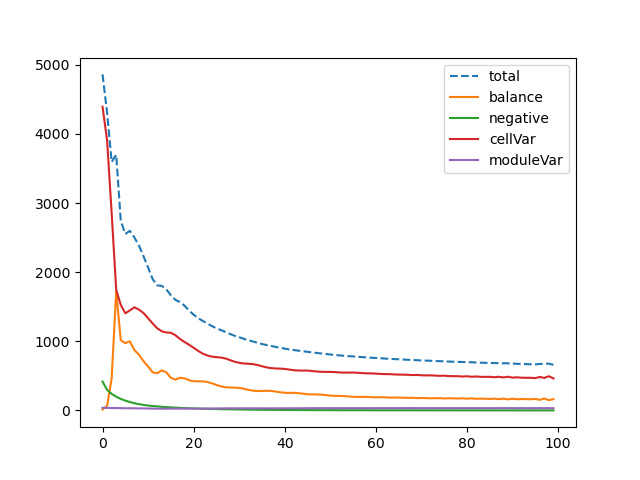

In [12]:
from IPython.display import Image
Image(filename='./scFEA/output/loss_20210923-112543.png') # make sure use correct file with time stamp

### 6. Downstream Analysis

(R package scFEA coming soon which includes downstream analysis and visualization of flux)

In [8]:
# use rpy2 to enable R and python in one jupyter notebook
%load_ext rpy2.ipython

R[write to console]: Picking joint bandwidth of 426



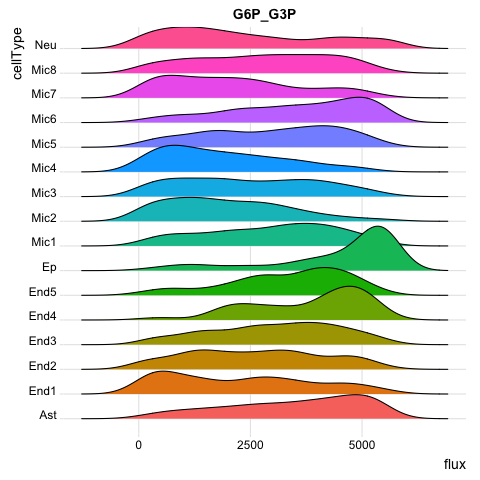

In [10]:
%%R
library(tidyverse)
library(rstatix)
library(ggpubr)
library(reshape)
library(ggridges)
library(ggplot2)

# load predicted flux
data_c <- read.csv('./scFEA/output/mouse_flux.csv')
data_c0 <- as.matrix(data_c[,-1])
rownames(data_c0) <- as.character(data_c[,1])
data_c0 <- t(data_c0)
ppp_all <-c()

# load cell label of mouse example data
load('./scFEA/input/mouse_example_cell_ident.RData')
yyy <- cell_id[colnames(data_c0)]
for(ii in 1:nrow(data_c0)){
    xxx <- data_c0[ii,]
    final_df <- cbind(paste('X', 1:length(xxx), sep=''), xxx, yyy)
    final_df <- as.data.frame(final_df)
    final_df[,2] <- as.numeric(final_df[,2])
    colnames(final_df) <- c('var', 'flux', 'cellType')
    pp <- sd(final_df$flux)/abs(mean(final_df$flux))
    ppp_all <- c(ppp_all, pp)
}
tg_ids <- which(ppp_all > 1e-10)

# load mouse module info
load('./scFEA/input/mouse_module_info.RData')
if(length(tg_ids) > 0){
    jj = 2 # check module 2
    xxx <- data_c0[tg_ids[jj], ]
    final_df <- cbind(paste('X', 1:length(xxx), sep=''), xxx, yyy)
    final_df <- as.data.frame(final_df)
    final_df[,2] <- as.numeric(final_df[,2])
    colnames(final_df) <- c('var', 'flux', 'cellType')
        
    title <- mouse_module_info[rownames(data_c0)[tg_ids[jj]], 'M_name']
    aa <- ggplot(final_df, aes(x = flux, y = cellType, fill = cellType)) +
                  geom_density_ridges() +
                  theme_ridges() +
                  theme(legend.position = 'none') +
                  ggtitle(title) +
                  theme(plot.title = element_text(hjust = 0.5))
    plot(aa)
    
}